In [1]:
import tensorflow as tf
from scipy.fftpack import dct
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [5]:
kernel_size = (20, 20)

def histo_equalize(img):
    lab_planes = cv2.split(img)
    eq_channels = []
    for ch in lab_planes:
        eq_channels.append(cv2.equalizeHist(ch))

    img = cv2.merge(eq_channels)

    img = cv2.cvtColor(img, cv2.COLOR_LAB2BGR)
    return img

def opening_ops(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return img

def closing_ops(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    return img

def gabor_filter(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    g_kernel = cv2.getGaborKernel(kernel_size, 8.0, np.pi/4, 10.0, 0.5, 0, ktype=cv2.CV_32F)
    img = cv2.filter2D(img, cv2.CV_8UC3, g_kernel)
    return img


def convert_SVD(img):
    img = np.mean(img, 2)

    U,s,V = np.linalg.svd(img)

    n = 255
    S = np.zeros(np.shape(img))
    for i in range(0, n):
        S[i,i] = s[i]

    img = U @ S @ V
    img = np.stack((img,)*3, axis=-1)
    return img

def convert_DCT(img):
    # implement 2D DCT
    img = dct(dct(img.T, norm='ortho').T, norm='ortho')
    # img = np.expand_dims(img, axis=-1)
    return img

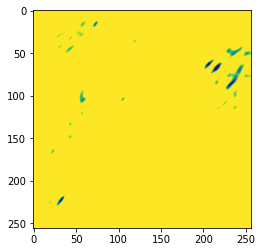

In [8]:
defect_img = cv2.imread("mura_data/RGB/test_data_nctu/defect/defect.png")

# defect_img = convert_SVD(defect_img)
# print(convert_SVD(defect_img).shape)
# print(convert_DCT(defect_img).shape)
# defect_img =  convert_DCT(defect_img) - convert_SVD(defect_img) + 128
# defect_img =  np.subtract(convert_DCT(defect_img), convert_SVD(defect_img))
# defect_img = np.add(defect_img, 128.0)


defect_img = cv2.cvtColor(defect_img, cv2.COLOR_BGR2LAB)

defect_img = opening_ops(defect_img)
defect_img = closing_ops(defect_img)
defect_img = histo_equalize(defect_img)
defect_img = gabor_filter(defect_img)
# defect_img = histo_equalize(defect_img)

# defect_img = cv2.cvtColor(defect_img, cv2.COLOR_GRAY2RGB)
    
plt.imshow(defect_img)

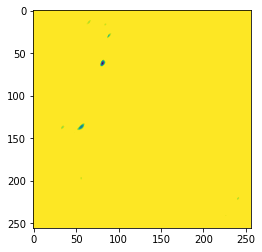

In [10]:
normal_img = cv2.imread("mura_data/RGB/test_data_nctu/normal/normal.png")
# normal_img = cv2.cvtColor(normal_img, cv2.COLOR_BGR2GRAY)
# normal_img = convert_SVD(normal_img)
# normal_img = convert_DCT(normal_img) - convert_SVD(normal_img) + 128
# normal_img = np.subtract(convert_DCT(defect_img), convert_SVD(defect_img))
# normal_img = np.add(normal_img, 128.0)


normal_img = cv2.cvtColor(normal_img, cv2.COLOR_BGR2LAB)

normal_img = opening_ops(normal_img)
normal_img = closing_ops(normal_img)
normal_img = histo_equalize(normal_img)
normal_img = gabor_filter(normal_img)
# normal_img = histo_equalize(normal_img)

# normal_img = cv2.cvtColor(normal_img, cv2.COLOR_GRAY2RGB)

plt.imshow(normal_img)